In [186]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as st
import math
from scipy.stats import pearsonr
import numpy as np

<h2> Here we are getting the data organized based on a specified starting year </h2>

In [187]:
#THIS IS THE YEAR WE WANT TO START AND FINISH CALCULATING THE AVERAGE FROM
#min year is 1980 because the stats are pretty sketchy prior

start_year = 2020
end_year = 2020

In [188]:
all_players_df = pd.read_csv("csv_files/player_stats_"+str(start_year)+".csv")
all_players_df = all_players_df.drop_duplicates('NAME', keep='first')
all_players_df['YEAR']= start_year

for year in range(start_year+1, end_year+1):
    
    #store current year in df
    current_year_players_df = pd.read_csv("csv_files/player_stats_"+str(year)+".csv")

    #since some players were traded during each season their stats are split first showing TOT (total season)
    #and the following rows showing their stats specific for their teams
    #since the total is always first we can drop all duplicates following the first instance (ASSUMING NO PLAYERS HAVE THE SAME NAME)
    current_year_players_df = current_year_players_df.drop_duplicates('NAME', keep='first')
    current_year_players_df['YEAR'] = year
    #appending the current year to all previous years 
    all_players_df = all_players_df.append(current_year_players_df, ignore_index=True)
    
    


In [424]:
#HERE WE WILL SET CRITERIA FOR OUR DATA BASE AND GET RID OF NANs

#filling null values with 0
players_df = all_players_df.replace(' ', 0).fillna(0)

#Need to reset index cause when a player has played  on multiple teams 
#then they show up multiple times and we only want season total
players_df = players_df.reset_index()

###### uncomment if you want only players that have played a certain number of games #####
# players_df = players_df[players_df['G'] > 25]



#players_df.head(50)

<h2> Getting Neccessary Data </h2> 

<p> Here we are getting player's season averages for points and minutes and their total games played. We are also storing all of the logged points and minutes for each game </p> 

In [425]:
#this array will store the values of points scored 
player_std = []

#this will deal with player percentages 


player_3_percent_std = []
player_fg_percent_std = []
player_ft_percent_std=  [] 

percent_arr = []

#going through every player tows
for index, player in players_df.iterrows():

       
    #storing average ppg and average min in variables to make more readabble
    avg_ppg = player['PTS']
    avg_min = player['MP']
    gp = player['G']
    
    #looking at percentages
    fg_percent = float(player['FG%'])
    #print(player['FG%'])

    
    fg_attempts = player['FGA']
    three_percent = player['3P%']
    three_attempts = player['3PA']
    ft_percent = player['FT%']
    ft_attempts = player['FTA']
    
    #names with III and Jr. don't connect to our game log datasets so we must fix the strings
    name = player['NAME'].replace(" III","").replace(" Jr.","").replace(" ","_")
    
    #just gonna hardcode the messed up names
    if name == 'Mo_Bamba':
        name = 'Mohamed_Bamba'
    elif name == 'Gary_Payton_II':
        name = 'Gary_Payton'
    elif name == 'Taurean_Prince':
        name = 'Taurean_Waller-Prince'
     
    #Keeping this in a try catch block just in case in the future we want to edit it for multiple seasons
    try:
        game_log_df = pd.read_csv("csv_files/"+ name +"_game_log_2020.csv")
    except:
        print(name + " this file does not exist")
        continue
 
    #Here we are measuring the standard deviation of a player 
    #the player must've played over one game for the calculation to work 
    if player['G'] > 1:
        std_pts = st.stdev(game_log_df['PTS'],avg_ppg)
        
    else: 
        continue
      

    #here we are getting min played 
    min_played = []
    for game_min in game_log_df['MP']:

        #turning MP into floats of min and seconds
        game_min = game_min.replace(":",".")
        min_and_sec = float(game_min)

        #converting to just units of minutes
        min_val = math.floor(min_and_sec)
        sec_val = min_and_sec % 1
        sec_val = sec_val / 0.6
        sec_val = round(sec_val,2)

        #appending the total min to list
        min_played.append(min_val + sec_val)
        
    #this gets the standard deviation of minutes played that will go into all of the arrays 
    std_min = st.stdev(min_played,avg_min)
    
    #this adds data involving points to the array  
    player_std.append([name,std_pts,std_min,avg_ppg,gp])
    

    #acquiring std's for different shooting percentages
    #some null values were stored as ' ' and some as NaNs hence the different forms written below
    std_fg_percent = st.stdev(game_log_df['FG%'].replace(' ',0).astype(float),fg_percent)
    std_3_percent = st.stdev(game_log_df['3P%'].fillna(0).astype(float),three_percent)
    std_ft_percent = st.stdev(game_log_df['FT%'].fillna(0).astype(float),ft_percent)
    

    #this adds data involving shooting percentages 
    player_fg_percent_std.append([name,std_min,fg_percent,fg_attempts,std_fg_percent]) 
    player_3_percent_std.append([ name,std_min,three_percent,three_attempts,std_3_percent])
    player_ft_percent_std.append([name,std_min,ft_percent,ft_attempts,std_ft_percent])
    
    #one big data frame 
    percent_arr.append([name,gp,std_min,fg_percent,fg_attempts,std_fg_percent,three_percent,three_attempts,std_3_percent,ft_percent,ft_attempts,std_ft_percent])

    
#We are going to turn these from lists to dataframes to make them easier to work with 
player_fg_percent_std = pd.DataFrame(player_fg_percent_std, columns = ['Name', 'STD_min','FG%','FGA','STD_FG%']) 
player_3_percent_std =  pd.DataFrame(player_3_percent_std, columns = ['Name', 'STD_min','3FG%','3FGA','STD_3FG%']) 
player_ft_percent_std=  pd.DataFrame(player_ft_percent_std, columns = ['Name', 'STD_min','FT%','FTA','STD_FT%']) 

#Big df
percent_df = pd.DataFrame(percent_arr,columns = ['Name','GP' ,'STD_min','FG%','FGA','STD_FG%','3FG%','3FGA','STD_3FG%','FT%','FTA','STD_FT%'] )
    
    


In [426]:
percent_df

,Name,GP,STD_min,FG%,FGA,STD_FG%,3FG%,3FGA,STD_3FG%,FT%,FTA,STD_FT%
0,Steven_Adams,58,5.648432,0.591,7.6,0.237482,0.333,0.1,0.131306,0.590,3.2,0.362527
1,Bam_Adebayo,65,4.533956,0.567,11.1,0.173166,0.077,0.2,0.124035,0.690,5.3,0.277755
2,LaMarcus_Aldridge,53,3.580425,0.493,15.0,0.114490,0.389,3.0,0.311673,0.827,3.6,0.307260
3,Nickeil_Alexander-Walker,41,8.173791,0.339,5.5,0.234427,0.342,2.9,0.281449,0.607,0.7,0.324889
4,Grayson_Allen,30,6.231980,0.449,5.9,0.231789,0.363,3.0,0.330486,0.857,1.2,0.460976
...,...,...,...,...,...,...,...,...,...,...,...,...
503,Thaddeus_Young,64,6.054923,0.448,9.4,0.151940,0.356,3.5,0.281860,0.583,1.1,0.367766
504,Trae_Young,60,6.086498,0.437,20.8,0.105367,0.361,9.5,0.167537,0.860,9.3,0.163008
505,Cody_Zeller,58,5.125455,0.524,8.3,0.183019,0.240,1.3,0.302604,0.682,3.1,0.380744
506,Ante_Žižić,22,6.349425,0.569,3.3,0.338498,0.000,0.0,0.000000,0.737,0.9,0.458948


<h1> Predicting STD Points Scored</h1>
<p> Here we are going to compute the predicted standard deviation in points scored relative to the number of points score and plot this prediction <p> 

In [427]:
import numpy as np
from numpy.linalg import inv


x = []
y = []

for player in player_std:
     
    x.append(player[3])
    y.append(player[1])
    
# making the arrays numpy 
x = np.array(x)
y = np.array(y)

#setting the highest degree of the vandermonde matrix
N = 4

#setting Matrix 
X = np.vander(x, 4, increasing=True)

#Our regression model will look like y = c0 + c1*x1 + c2*x2^2 + c3*x3^3
#To get these values of c we use: c = (X^T*X)^-1*X^T*y

XT = X.transpose()

#c = (X^T*X)^-1*X^T*y
c = np.matmul(inv(np.matmul(XT,X)),np.matmul(XT,y))


#this is the polynomial of our prediction curve 
def prediction(x):
   
    return c[0] + c[1]*x + c[2]*(x**2) + c[3]*(x**3)



import plotly.express as px
import plotly.graph_objects as go


x_graph = np.linspace(0,40,100)
y_graph = prediction(x_graph)


fig1 = px.scatter(x = x,
                 y = y,
                 hover_name=percent_df['Name'],
                 labels = {
                         "x" : "Average PPG",
                         "y" : "Inconsistency"
                        },
                 title = "3FG% vs STD 3FG%"
                )

fig2 = px.line(
    x = x_graph,
    y = y_graph
)



from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(fig1.data[0], secondary_y=False)
fig.add_trace(fig2.data[0], secondary_y=False)

fig.update_layout(
    yaxis=dict(
        title='Inconsistency '),
    xaxis=dict(
        title='Average PPG'),
    title = "Average PPG vs STD In Points Scored" )


fig.layout.template = 'plotly'



fig.show()




<h2> Computing Residual values </h2>

In [428]:
residual_values = []

#going through all players
for player in player_std:
    
    #getting data from player 
    name = player[0]
    std_points = player[1]
    std_min = player[2]
    avg_pts = player[3]
    gp = player[4]
    
    #computing the residual value 
    residual = std_points - prediction(avg_pts)
    
    residual_values.append([name, residual,std_min, avg_pts,gp])


residual_values.sort(key=lambda x:x[1], reverse = True)




In [429]:
residual_values

[['Kyrie_Irving', 3.78028115083268, 4.672006528248864, 27.4, 20],
 ['Garrison_Mathews', 2.8260006855996442, 7.632374650818546, 5.4, 18],
 ['Shake_Milton', 2.755764144974326, 11.362317105238702, 9.5, 32],
 ['C.J._Miles', 2.592136406168006, 5.414998614958272, 6.4, 10],
 ['Caris_LeVert', 2.5722101813498766, 6.154152356585769, 17.7, 39],
 ['Naz_Mitrou-Long', 2.36174150907871, 11.486439831383787, 4.7, 3],
 ['Kemba_Walker', 2.3531652026857675, 5.353242526826186, 21.2, 50],
 ['Dwayne_Bacon', 2.1106648324028185, 8.937059787862106, 5.7, 39],
 ['Norman_Powell', 2.086137500194644, 7.349669751393287, 16.4, 44],
 ['Damian_Lillard', 2.063639752282919, 3.761713788037242, 28.9, 58],
 ['Admiral_Schofield', 2.0474783124530105, 9.261233803708421, 3.1, 27],
 ['Chris_Clemons', 2.0458539356961287, 8.055187815247777, 4.9, 29],
 ['Paul_George', 1.9683617993312188, 6.185420289515974, 21.0, 42],
 ['Eric_Gordon', 1.9556156384478918, 5.67185609083583, 14.5, 34],
 ['Jordan_McRae', 1.8980551003390342, 9.42992033091

In [430]:
df = pd.DataFrame(residual_values,columns=["Name", "Inconsistency", "STD Minutes", "AVG Points", "Games Played"])
df

,Name,Inconsistency,STD Minutes,AVG Points,Games Played
0,Kyrie_Irving,3.780281,4.672007,27.4,20
1,Garrison_Mathews,2.826001,7.632375,5.4,18
2,Shake_Milton,2.755764,11.362317,9.5,32
3,C.J._Miles,2.592136,5.414999,6.4,10
4,Caris_LeVert,2.572210,6.154152,17.7,39
...,...,...,...,...,...
503,Danilo_Gallinari,-1.989762,2.817508,19.2,55
504,Zion_Williamson,-2.028905,4.317601,23.6,19
505,Ryan_Anderson,-2.058173,4.030509,2.5,2
506,Marvin_Bagley,-3.694931,5.051487,14.2,13


<h2> Analyzing data </h2>

In [431]:
df.corr().round(3)

,Inconsistency,STD Minutes,AVG Points,Games Played
Inconsistency,1.000,0.434,-0.000,-0.025
STD Minutes,0.434,1.000,-0.119,0.162
AVG Points,-0.000,-0.119,1.000,0.556
Games Played,-0.025,0.162,0.556,1.000


In [432]:
import plotly.express as px
fig = px.scatter_matrix(df,
                       width= 1500,
                       height = 1000,
                       dimensions= ['STD Minutes', 'Inconsistency','AVG Points','Games Played'],
                       hover_name = "Name" 
                       )
fig.show()

<h2> Code to look at players scoring distrobution </h2> 

[]

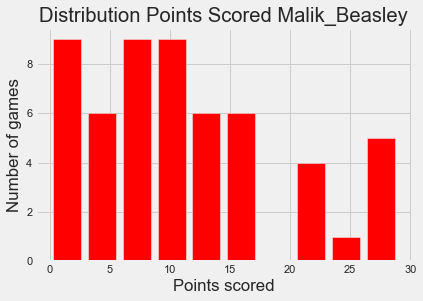

In [433]:
name = "Malik_Beasley"
game_log_df = pd.read_csv("csv_files/"+ name +"_game_log_2020.csv")


plt.style.use('fivethirtyeight')

#making the plot 
pts_dist, g = plt.subplots()

g.hist(game_log_df['PTS'],color='red',bins=10,rwidth=0.8)
g.set_xlabel("Points scored")
g.set_ylabel("Number of games")
g.set_title("Distribution Points Scored " + name)
g.plot()

<h1> Now we will look at inconsistency in shooting percentage</h1>

In [434]:
player_fg_percent_std 
player_ft_percent_std
player_3_percent_std 

,Name,STD_min,3FG%,3FGA,STD_3FG%
0,Steven_Adams,5.648432,0.333,0.1,0.131306
1,Bam_Adebayo,4.533956,0.077,0.2,0.124035
2,LaMarcus_Aldridge,3.580425,0.389,3.0,0.311673
3,Nickeil_Alexander-Walker,8.173791,0.342,2.9,0.281449
4,Grayson_Allen,6.231980,0.363,3.0,0.330486
...,...,...,...,...,...
503,Thaddeus_Young,6.054923,0.356,3.5,0.281860
504,Trae_Young,6.086498,0.361,9.5,0.167537
505,Cody_Zeller,5.125455,0.240,1.3,0.302604
506,Ante_Žižić,6.349425,0.000,0.0,0.000000


In [435]:
percent_df.corr().round(3)

,GP,STD_min,FG%,FGA,STD_FG%,3FG%,3FGA,STD_3FG%,FT%,FTA,STD_FT%
GP,1.000,0.162,0.376,0.548,-0.325,0.399,0.444,0.314,0.460,0.416,0.404
STD_min,0.162,1.000,0.182,-0.102,0.184,0.182,-0.021,0.311,0.156,-0.157,0.270
FG%,0.376,0.182,1.000,0.211,0.317,0.251,-0.058,0.137,0.277,0.259,0.316
FGA,0.548,-0.102,0.211,1.000,-0.627,0.342,0.770,0.111,0.384,0.835,0.101
STD_FG%,-0.325,0.184,0.317,-0.627,1.000,-0.124,-0.537,0.032,-0.113,-0.470,0.020
3FG%,0.399,0.182,0.251,0.342,-0.124,1.000,0.444,0.728,0.345,0.160,0.255
3FGA,0.444,-0.021,-0.058,0.770,-0.537,0.444,1.000,0.161,0.368,0.510,0.121
STD_3FG%,0.314,0.311,0.137,0.111,0.032,0.728,0.161,1.000,0.274,-0.005,0.270
FT%,0.460,0.156,0.277,0.384,-0.113,0.345,0.368,0.274,1.000,0.307,0.786
FTA,0.416,-0.157,0.259,0.835,-0.470,0.160,0.510,-0.005,0.307,1.000,-0.028


In [436]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_matrix(player_fg_percent_std,
                       dimensions= ['STD_min', 'FG%','FGA','STD_FG%'],
                       width= 1500,
                       height = 1000,
                       hover_name = "Name")
fig.show()

<h3> Code to look deeper at some graphs </h3> 

In [437]:
import plotly.express as px

fig = px.scatter(x = percent_df['3FG%'],
                 y =percent_df['STD_3FG%'],
                 hover_name=percent_df['Name'],
                 trendline="ols",
                 labels = {
                         "x" : "3 point percentage",
                         "y" : "STD 3 point percentage"
                        },
                 title = "3FG% vs STD 3FG%"
                )
fig.show()

<h3> Three point shooting </h3>

In [439]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_matrix(percent_df,
                       dimensions= ['STD_min', '3FG%','3FGA','STD_3FG%'],
                       width= 1500,
                       height = 1000,
                       hover_name = "Name")
fig.show()




<h3> Taking a look at free throw shooting </h3>

In [441]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_matrix(percent_df,
                       dimensions= ['STD_min', 'FT%','FTA','STD_FT%'],
                       width= 1500,
                       height = 1000,
                       hover_name = "Name")
fig.show()
